# Bayesian Neural Network

* 0. import
* 1. functions
* 2. create data
* 3. train "classical" NeuralNetwork
* 4. functions for Bayesian Neural Network
* 5. train Bayesian Neural Network 1. Laplace approximation
* 6. train Bayesian Neural Network 2-1. HMC
* 7. train Bayesian Neural Network 2-2. HMC+Gibbs sampler)
* 8. train Bayesian Neural Network 3. stochastic variational inference

## 0. Import

In [1]:
using LinearAlgebra
using ForwardDiff
using Random 
using Statistics
using Distributions
using ProgressMeter
using Optim
using Plots
pyplot()

Plots.PyPlotBackend()

## 1. functions

In [2]:
#initialize the parameter
function init_params(Dx, D₀, Dy)
    W₂ = rand(D₀, Dx)
    W₃ = rand(Dy, D₀)
    b₂ = zeros(D₀)
    b₃ = zeros(Dy)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(params_vec, Dx, D₀, Dy)
    W = reshape(params_vec, (Dx+Dy+1, D₀+1))
    W₂ = view(W, 2:Dx+1, 1:D₀)'
    W₃ = view(W, Dx+2:Dx+Dy+1, 1:D₀)
    b₂ = view(W, 1, 1:D₀)
    b₃ = view(W, Dx+2:Dx+Dy+1, D₀+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ)) 

#Neural Network
function Φ(x, params_vec, Dx, D₀, Dy)
    W₂, W₃, b₂, b₃ = reshape_params(params_vec, Dx, D₀, Dy)
    return σ.(W₃*σ.(W₂*x+b₂) + b₃)
end

#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[1,k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[1,k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#plot the probability to classify new data to class 1(red point)
function plot_prob_1(X, Y, pred_func, title)
    T = 50
    X1s = range(0,1,length=T)
    X2s = range(0,1,length=T)
    preds = zeros(T,T)
    @showprogress for j in 1:T
        x2 = X2s[j]
        for i in 1:T
            x1 = X1s[i]
            preds[i,j] = pred_func([x1,x2])
        end
    end
    fig = heatmap(X1s, X2s, preds, c=cgrad(:coolwarm), alpha=0.6, title=title)
    return plot_data(fig, X, Y)
end

plot_prob_1 (generic function with 1 method)

## 2. creating the data

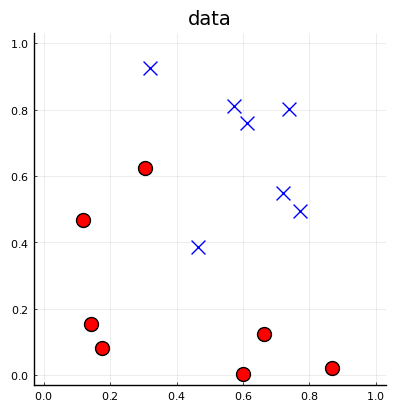

In [3]:
#create the data
Random.seed!(46)
N = 14
X = hcat(rand(Beta(1.1,3), 2, div(N,2)), rand(Beta(1.9,1.1), 2, div(N,2)))
Y = vcat(vcat(ones(div(N,2)), zeros(div(N,2)))', vcat(zeros(div(N,2)), ones(div(N,2)))')

#plot the data
fig1 = plot_data(X, Y)
savefig(fig1, "figs-BNN/fig1.png")

## 3. training a "classical" Neural Network

In [4]:
# loss function 
Ln(y_pred, y_data) = norm(y_pred-y_data)^2

#train the neural network
function train_nn(wvec, Φ, X, Y, D₀, n_train, tol, ϵ)
    Dx, N = size(X)
    Dy, N = size(Y)
    
    #gradient of the loss function
    ∇Ln(wvec, idx) = ForwardDiff.gradient(wvec->Ln(Φ(X[:,idx], wvec), Y[:,idx]), wvec)
    
    @showprogress for i in 1:n_train
        #choose the sample uniformaly
        idx = rand(1:N)
        
        #gradient descent
        wvec = wvec - ϵ*∇Ln(wvec, idx)
    end
    return wvec
end

#predict the class for new data
function predict_prob_1(x, wvec, Φ)
    pred = Φ(x, wvec)
    return pred[1]/sum(pred)
end

predict_prob_1 (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:116:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


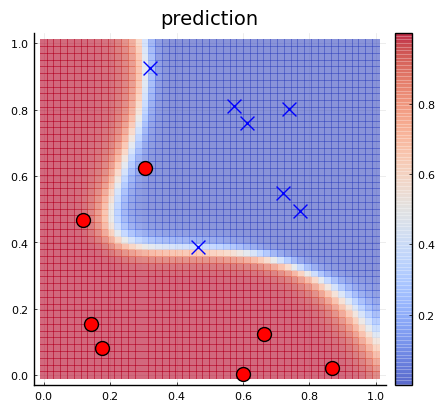

In [5]:
#initialize the parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ = 5
W₂, W₃, b₂, b₃ = init_params(Dx, D₀, Dy)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]

#Neural Network 
Φ(x,wvec) = Φ(x, wvec, Dx, D₀, Dy)

#train the network
n_train = Int(1e6)
tol = 1e-5 #tolerance of SGD
ϵ = 1e-1 #learning rate of SGD
wvec = train_nn(wvec₀, Φ, X, Y, D₀, n_train, tol, ϵ)

#predict
fig2 = plot_prob_1(X, Y, x->predict_prob_1(x, wvec, Φ), "prediction")
savefig(fig2, "figs-BNN/fig2.png")

## 4. function : Bayesian Neural Network

In [6]:
#prior for each element
prior_dist(λw) = Normal(0, 1/√λw)
logpprior(w, λw) = logpdf(prior_dist(λw), w)
pprior(w, λw) = exp(logpprior(w, λw))

#model
logpmodel(y, x, wvec, Φ) = log(dot(y, Φ(x,wvec))/sum(Φ(x,wvec)))
pmodel(y, x, wvec, Φ) = exp(logpmodel(y, x, wvec, Φ))

#liklihood
loglik(wvec, Φ, X, Y, N) = sum([logpmodel(Y[:,n], X[:,n], wvec, Φ) for n in 1:N])

#posterior
logppost(wvec, λw, Φ, X, Y, N) = sum(logpprior(wvec,λw)) + loglik(wvec, Φ, X, Y, N)
ppost(wvec, λw, Φ, X, Y, N) = exp(logppost(wvec, λw, Φ, X, Y, N))

#predictive: returns the probability to new data classify to class 1
function ppred(x, wsamps, pmodel)
    _,n_samps = size(wsamps)
    preds = zeros(n_samps)
    for i in 1:n_samps
        preds[i] = pmodel([1,0], x, wsamps[:,i])
    end
    return mean(preds)
end

ppred (generic function with 1 method)

## 5. training a Bayesian Neural Network : 1. Laplace approximation

In [7]:
#calculate the MAP estimate of parameters
function calc_MAP(wvec₀, logppost)
    opt = Optim.optimize(logppost, wvec₀, BFGS())
    return opt.minimizer
end

#calculate the MAP estimate and Hesse matrix
function calc_params(wvec₀, logppost)
    logppost_neg(wvec) = -logppost(wvec)
    wvec_MAP = calc_MAP(wvec₀, logppost_neg)
    H = ForwardDiff.hessian(logppost_neg, wvec_MAP)
    return wvec_MAP, Matrix(Hermitian(H))
end

calc_params (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


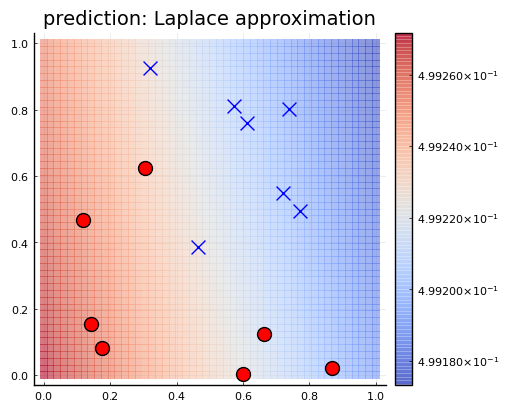

In [8]:
#initialize the parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ = 5
W₂, W₃, b₂, b₃ = init_params(Dx, D₀, Dy)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]

#hyperparamter
λw = 1/0.2^2

#Neural Network 
Φ(x, wvec) = Φ(x, wvec, Dx, D₀, Dy) 

#model, posterior, predictive
pmodel(y, x, wvec) = pmodel(y, x, wvec, Φ)
logppost(wvec) = logppost(wvec, λw, Φ, X, Y, N)
ppred(x, wsamps) = ppred(x, wsamps, pmodel)

#MAP estimate and Hesse matrix
wvec_MAP, H = calc_params(wvec₀, logppost)

#approximated normal distribution
post_normal = MvNormalCanon(wvec_MAP, H)

#posterior sample
n_samps = 5000
wsamps = rand(post_normal, n_samps)

# #plot the result
fig3 = plot_prob_1(X, Y, x->ppred(x, wsamps), "prediction: Laplace approximation")
savefig(fig3, "figs-BNN/fig3.png")

## 6. training a Bayesian Neural Network : 2-1. HMC

In [9]:
#one step of Störmer-Verlet method
function myStörmerVerlet(qvec, pvec, h, f)
    p_mid = pvec + h * f(qvec)/2;
    q_new = qvec + h * p_mid;
    p_new = p_mid + h * f(q_new)/2;
    return q_new, p_new
end

#update the position
function update(T, h, f, qvec, pvec)
    qvec_new = qvec
    pvec_new = pvec
    for t in 1:T
        qvec_new, pvec_new = myStörmerVerlet(qvec_new, pvec_new, h, f)
    end
    return qvec_new, pvec_new
end

#MH acceptance and rejection
function accept_or_reject(xvec, xvec_old, pvec, pvec_old, H)
    ΔH = H(xvec, pvec)-H(xvec_old, pvec_old)
    α = min(1.0, exp(-ΔH))
    u = rand()
    if u≤α
        return xvec, pvec
    else
        return xvec_old, pvec_old
    end
end

#Hamiltonian Monte Carlo
function myHMC(x₀, n_samps, n_burnin, pdf_func, T, h)
    #initialization
    d = length(x₀)
    xsamps = zeros(d, n_samps)
    xsamps[:,1] = x₀
    xvec = zeros(d)
    pvec = zeros(d)
    
    #Hamiltonian and potential
    U(xvec) = -log(pdf_func(xvec))
    ∇Uneg(xvec) = -ForwardDiff.gradient(U, xvec)
    H(xvec, pvec) = U(xvec) + norm(pvec)^2/2
    
    #sample
    xvec_old = x₀
    pvec_old = randn(d)
    @showprogress for i in 2:n_samps
        pvec = randn(d)
        xvec, pvec = update(T, h, ∇Uneg, xvec, pvec)
        xvec, pvec = accept_or_reject(xvec, xvec_old, pvec, pvec_old, H)
        xsamps[:,i] = xvec
        xvec_old = xvec
        pvec_old = pvec
    end
    return xsamps[:,n_burnin:end]
end

myHMC (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


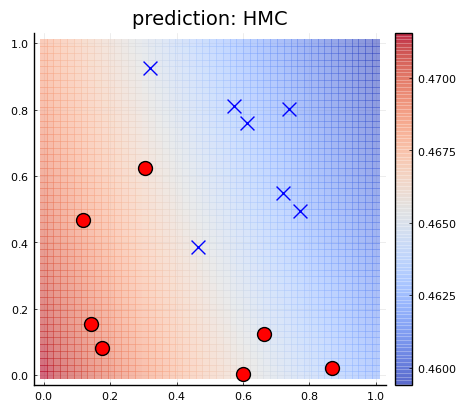

In [10]:
#initialize the parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ =5
W₂, W₃, b₂, b₃ = init_params(Dx, D₀, Dy)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]

#hyperparamter
λw = 1/0.6^2

#Neural Network 
Φ(x, wvec) = Φ(x, wvec, Dx, D₀, Dy) 

#model, posterior, predictive
pmodel(y, x, wvec) = pmodel(y, x, wvec, Φ)
logppost(wvec) = logppost(wvec, λw, Φ, X, Y, N)
ppost(wvec) = exp(logppost(wvec))
ppred(x, wsamps) = ppred(x, wsamps, pmodel)

#HMC
n_samps = 5000
n_burnin = div(n_samps,10)
T = 100
h = 0.3
wsamps = myHMC(wvec₀, n_samps, n_burnin, ppost, T, h)

#plot the result
fig4 = plot_prob_1(X, Y, x->ppred(x, wsamps), "prediction: HMC")
savefig(fig4, "figs-BNN/fig4.png")

## 7. training a Bayesian Neural Network : 2-2. HMC + Gibbs sampler

In [11]:
#Hamiltonian Monte Carlo for hierarchical model
function myHMC_HM(x₀, λw₀, n_samps, n_burnin, pdf_func, T, h)
    #initialization
    d = length(x₀)
    xsamps = zeros(d, n_samps)
    xsamps[:,1] = x₀
    λwsamps = zeros(n_samps)
    λwsamps[1] = λw₀
    xvec = zeros(d)
    pvec = zeros(d)
    
    #paramter of λw
    α = 1
    β = 1e4
    λw = λw₀
    
    #Hamiltonian and potential
    U(xvec, λw) = -log(pdf_func(xvec, λw))
    ∇Uneg(xvec, λw) = -ForwardDiff.gradient(xvec->U(xvec, λw), xvec)
    H(xvec, pvec, λw) = U(xvec, λw) + norm(pvec)^2/2
    
    #sample
    xvec_old = x₀
    pvec_old = randn(d)
    @showprogress for i in 2:n_samps
        pvec = randn(d)
        xvec, pvec = update(T, h, xvec->∇Uneg(xvec, λw), xvec, pvec)
        xvec, pvec = accept_or_reject(xvec, xvec_old, pvec, pvec_old, (xvec, pvec)->H(xvec, pvec, λw))
        xsamps[:,i] = xvec
        λw = rand(Gamma(α+d/2, 1/(β+norm(xvec)^2/2)))
        λwsamps[i] = λw
        xvec_old = xvec
        pvec_old = pvec
    end
    return xsamps[:,n_burnin:end], λwsamps[n_burnin:end]
end   

myHMC_HM (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:55
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


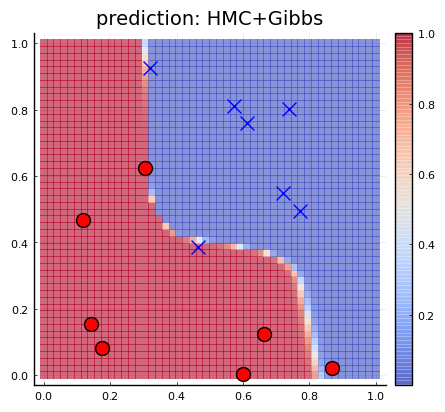

In [12]:
#initialize the parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ =5
W₂, W₃, b₂, b₃ = init_params(Dx, D₀, Dy)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]

#initialize hyperparamter
λw₀ = 1/0.6^2

#Neural Network 
Φ(x, wvec) = Φ(x, wvec, Dx, D₀, Dy) 

#model, posterior, predictive
pmodel(y, x, wvec) = pmodel(y, x, wvec, Φ)
logppost(wvec, λw) = logppost(wvec, λw, Φ, X, Y, N)
ppost(wvec, λw) = exp(logppost(wvec, λw))
ppred(x, wsamps) = ppred(x, wsamps, pmodel)

#HMC
n_samps = 5000
n_burnin = div(n_samps,10)
T = 100
h = 0.3
wsamps, λwsamps = myHMC_HM(wvec₀, λw₀, n_samps, n_burnin, ppost, T, h)

#plot the result
fig5 = plot_prob_1(X, Y, x->ppred(x, wsamps), "prediction: HMC+Gibbs")
savefig(fig5, "figs-BNN/fig5.png")

## 8. training a Bayesian Neural Network : 3. Stochastic Variational Inference

In [13]:
#∇logr
function ∇logr(wvec, params)
    d = length(wvec)
    μs = params[1:d]
    λs = params[d+1:end]
    ∇μs = λs .* (wvec - μs)
    ∇λs = (1 ./λs - (wvec - μs).^2)/2
    return vcat(∇μs, ∇λs)
end

#function : Er[f]
f(x, y, params, wvec, logpmodel) = logpmodel(y, x, wvec) * ∇logr(wvec, params)

#sample func
function sample_from_r(params)
    d = div(length(params), 2)
    samp = zeros(d)
    for j in 1:d
        μj = params[j]
        λj = params[d+j]
        samp[j] = rand(Normal(μj, 1/√λj))
    end
    return samp
end
    
#MC approximation : expectation with respect to r(w)
function Er(x, y, params, n_samps, f)
    d = div(length(params), 2)
    Esamps = zeros(2*d, n_samps)
    samp = zeros(d)
    for i in 1:n_samps
        samp = sample_from_r(params)
        Esamps[:,i] = f(x, y, params, samp, logpmodel)
    end
    return mean(Esamps, dims=2)
end

#gradient Kullback-Leibler divergence with respect to variational parameter
function ∇DKL(params, λw)
    d = div(length(params), 2)
    μs = params[1:d]
    λs = params[d+1:end]
    ∇μDKL = λw * μs
    ∇λDKL = (1 ./λs - λw./λs.^2)/2
    return vcat(∇μDKL, ∇λDKL)
end

#∇ELBO
∇ELBO(x, y, params, n_samps, λw) = Er(x, y, params, n_samps, f) - ∇DKL(params, λw)

#variational infernce
function myVI(X, Y, λw, n_train, n_samps, d, ϵ)
    _, N = size(X)
    params = vcat(zeros(d), ones(d))
    @showprogress for k in 1:n_train
        idx = rand(1:N)
        x = X[:,idx]
        y = Y[:,idx]
        params += ϵ  * N * ∇ELBO(x, y, params, n_samps, λw) / k
    end
    return params
end

#sample from posterior
function sample_from_posterior(params, n_samps)
    d = div(length(params), 2)
    wsamps = zeros(d, n_samps)
    for j in 1:d
        μj = params[j]
        λj = params[d+j]
        wsamps[j,:] = rand(Normal(μj, 1/√λj), n_samps)
    end
    return wsamps
end

#calculate WAIC
function calc_WAIC(X, Y, wsamps, pmodel, logpmodel)
    _,N = size(X)
    _,n_samps = size(wsamps)
    logpreds = zeros(N)
    vars = zeros(N)
    for n in 1:N
        logpreds[n] = -log(mean([pmodel(Y[:,n], X[:,n], wsamps[:,i]) for i in 1:n_samps]))
        vars[n] = var([logpmodel(Y[:,n], X[:,n], wsamps[:,i]) for i in 1:n_samps])
    end
    return mean(logpreds) + mean(vars)
end

#model selection
function model_selection(X, Y, λws, n_samps, ϵ, pmodel, logpmodel)
    n_train = 1000
    M = length(λws)
    WAICs = zeros(M)
    for i in 1:M
        params = myVI(X, Y, λws[i], n_train, n_samps, d, ϵ)    
        wsamps = sample_from_posterior(params, n_samps)
        WAICs[i] = calc_WAIC(X, Y, wsamps, pmodel, logpmodel)
    end
    return WAICs
end

model_selection (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


λw=99.99999999999999 minimize WAIC (std=0.1). 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


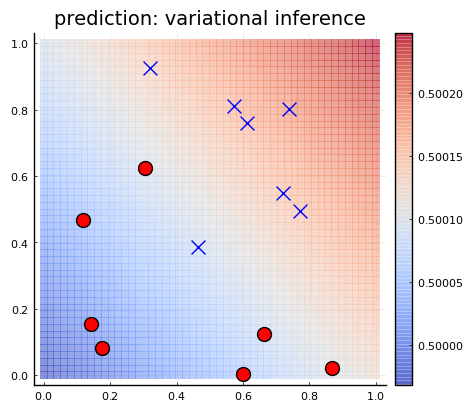

In [14]:
#initialize the parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ = 5
W₂, W₃, b₂, b₃ = init_params(Dx, D₀, Dy)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]
d = length(wvec₀)

#Neural Network 
Φ(x, wvec) = Φ(x, wvec, Dx, D₀, Dy) 

#model, posterior, predictive
logpmodel(y, x, wvec) = logpmodel(y, x, wvec, Φ)
pmodel(y,x,wvec) = exp(logpmodel(y, x, wvec))
ppred(x, wsamps) = ppred(x, wsamps, pmodel)

#model selection
ϵ = 0.01
λws = 1 ./ collect(0.1:0.1:1.0) .^2
WAICs = model_selection(X, Y, λws, 5000, ϵ, pmodel, logpmodel)
λw = λws[argmin(WAICs)]
println("λw=$(λw) minimize WAIC (std=$(1/sqrt(λw))). ")

#calculate the variational parameters
n_train = 1000
n_samps = 5000
params = myVI(X, Y, λw, n_train, n_samps, d, ϵ)

#posterior sample
wsamps = sample_from_posterior(params, n_samps)

#plot the result
fig6 = plot_prob_1(X, Y, x->ppred(x, wsamps), "prediction: variational inference")
savefig(fig6, "figs-BNN/fig6.png")